## TASK 4
### EMAIL SPAM DETECTION WITH MACHINE LEARNING


We've all been the recipient of spam emails before. Spam mail, or junk mail, is a type of email that is sent to a massive number of users at one time, frequently containing cryptic messages, scams, or most dangerously, phishing content.

In this Project, use Python to build an email spam detector. Then, use machine learning to train the spam detector to recognize and classify emails into spam and non-spam. Let's get started!


DOWNLOAD DATASET FROM HERE: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset




In [4]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from torchtext.data.utils import get_tokenizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from collections import Counter
import re

import warnings
warnings.filterwarnings('ignore')

In [8]:
# Load the dataset
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
data.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
data.label.unique()

array(['ham', 'spam'], dtype=object)

In [12]:
data.shape

(5572, 2)

In [13]:
data.isnull().sum()

label    0
text     0
dtype: int64

## Identifying the most frequently used words in different types of emails

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
def most_common_words(data, label, n):
  emails = data[data['label'] == label].text
  words = re.sub(r'[^a-zA-Z ]', '', ' '.join(emails)).lower().split()
  word_counts = Counter([word for word in words if word not in set(stopwords.words("english"))])
  most_common = word_counts.most_common(n)
  return most_common

In [16]:
spam_common = most_common_words(data, 'spam', 15)

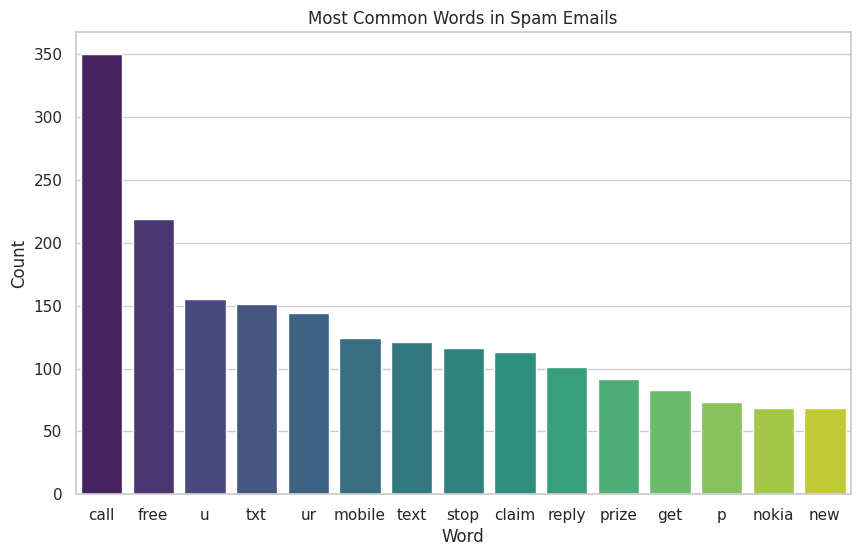

In [17]:
# Plot the most common words in spam emails
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=[word for word, count in spam_common], y=[count for word, count in spam_common], palette=sns.color_palette("viridis", 15))
plt.title('Most Common Words in Spam Emails')
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [18]:
ham_common = most_common_words(data, 'ham', 15)

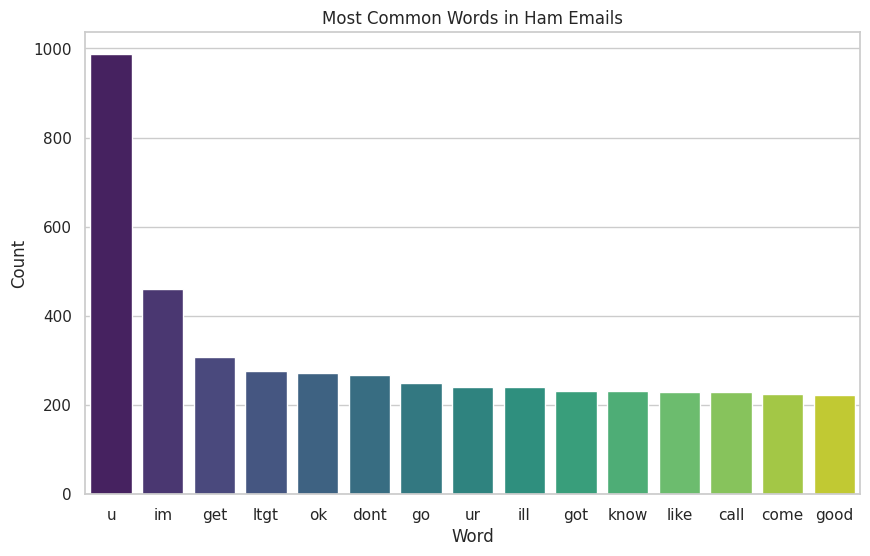

In [19]:
# Plot the most common words in non-spam emails
plt.figure(figsize=(10, 6))
sns.barplot(x=[word for word, count in ham_common], y=[count for word, count in ham_common], palette=sns.color_palette("viridis", 15))
plt.title('Most Common Words in Ham Emails')
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()


Based on the analysis of the most frequent words in spam and non-spam emails, several observations can be made:

1. In spam emails, words like "call", "free", "txt", "claim", and "prize" are among the most common. These words are often associated with promotional or fraudulent content, indicating attempts to entice recipients with offers or incentives.
2. Conversely, non-spam emails commonly contain words like "u", "im", "dont", "go", and "ill". These words are typically used in casual or conversational contexts and are less indicative of promotional or fraudulent content.

## Preprocessing of data for training a model

In [20]:
# Tokenization and stemming
tokenizer = get_tokenizer('basic_english')
stop_words = stopwords.words('english')
stemmer = PorterStemmer()

In [21]:
def preprocess_text(sentence):
  words = re.sub(r'[^a-zA-Z ]', '', sentence).lower().split()
  words = [word for word in words if word not in stop_words]
  words = [stemmer.stem(word) for word in words]
  return words

In [38]:
def process_inputs(sentence):
  inputs = torch.LongTensor([word_to_index.get(word, word_to_index['UNK']) for word in sentence.split()])
  return inputs

In [22]:
# Get unique words from the dataset
unique_words = set()
for text in data['text']:
  unique_words.update(preprocess_text(text))

unique_words_list = list(unique_words)
unique_words_list[:10]

['issu',
 'woodland',
 'safeti',
 'lost',
 'fal',
 'itplspl',
 'splashmobil',
 'wahay',
 'howev',
 'reciev']

In [23]:
# Create word-to-index mapping
PAD = 0
UNK = 1
word_to_index = {word: index + 2 for index, word in enumerate(unique_words_list)}
word_to_index['PAD'] = PAD
word_to_index['UNK'] = UNK
list(word_to_index.items())[:10]

[('issu', 2),
 ('woodland', 3),
 ('safeti', 4),
 ('lost', 5),
 ('fal', 6),
 ('itplspl', 7),
 ('splashmobil', 8),
 ('wahay', 9),
 ('howev', 10),
 ('reciev', 11)]

In [24]:
print(len(word_to_index))

7075


In [26]:
# Update the 'label' column to numerical values
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

In [31]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [33]:
train_data.shape, test_data.shape

((4457, 2), (1115, 2))

## Defining and training the model

In [45]:
class TextClassificationCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextClassificationCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        conved1 = nn.functional.relu(self.conv1(embedded))
        conved2 = nn.functional.relu(self.conv2(conved1))
        conved3 = nn.functional.relu(self.conv3(conved2))
        pooled = nn.functional.max_pool1d(conved3, kernel_size=conved3.shape[2])
        pooled = pooled.squeeze(2)
        pooled = self.dropout(pooled)
        return self.fc(pooled)

In [46]:
# Dataset class for training data
class EmailDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        text = sample['text']
        label = sample['label']
        return {'text': text, 'label': label}

In [47]:
# Training parameters
vocab_size = len(unique_words_list) + 2
embed_dim = 100
learning_rate = 0.05
num_epochs = 20
batch_size = 64
num_classes = 2
model = TextClassificationCNN(vocab_size, embed_dim, num_classes)

# Prepare data for training
train_dataset = EmailDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Prepare data for testing
test_dataset = EmailDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [48]:
history_train = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in train_dataloader:
        texts = batch['text']
        labels = batch['label']

        optimizer.zero_grad()
        max_len = max([len(process_inputs(text)) for text in texts])

        # Pad all texts to have the same length
        padded_texts = [torch.cat((process_inputs(text), torch.full((max_len - len(process_inputs(text)),), word_to_index['UNK'], dtype=torch.long))) for text in texts]

        # Stack the padded texts
        inputs = torch.stack(padded_texts)
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Print loss after each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_dataloader)}')
    history_train.append(epoch_loss / len(train_dataloader))

Epoch 1/20, Loss: 0.4080970615148544
Epoch 2/20, Loss: 0.39397469567401067
Epoch 3/20, Loss: 0.38348256030253003
Epoch 4/20, Loss: 0.36557253577879495
Epoch 5/20, Loss: 0.3359951960189002
Epoch 6/20, Loss: 0.30808547884225845
Epoch 7/20, Loss: 0.2794392819915499
Epoch 8/20, Loss: 0.26217083909681865
Epoch 9/20, Loss: 0.24816511912005287
Epoch 10/20, Loss: 0.2254796639084816
Epoch 11/20, Loss: 0.21442331214036262
Epoch 12/20, Loss: 0.19395252519420214
Epoch 13/20, Loss: 0.18050747673426357
Epoch 14/20, Loss: 0.17891482104148185
Epoch 15/20, Loss: 0.17203775335635457
Epoch 16/20, Loss: 0.15421058615403516
Epoch 17/20, Loss: 0.15258265856121267
Epoch 18/20, Loss: 0.13808133538280215
Epoch 19/20, Loss: 0.13085695377417972
Epoch 20/20, Loss: 0.12724547029605934



The model's loss consistently decreases over the 20 epochs, indicating steady improvement and effective learning. This suggests the model is converging towards an optimal solution, promising good performance.

## Testing model

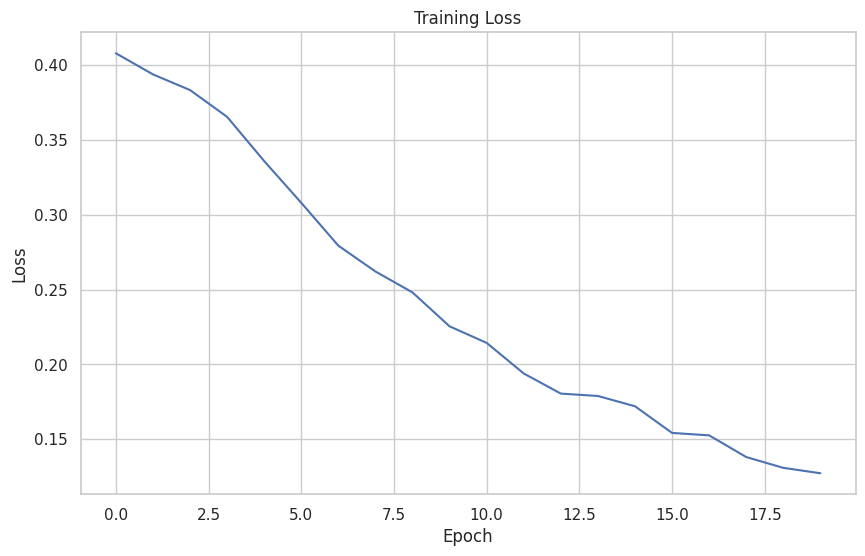

In [50]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(history_train)), y=history_train)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [53]:
model.eval()
correct = 0
total = 0
predictions = []


for batch in test_dataloader:
    texts = batch['text']
    labels = batch['label']

    max_len = max([len(process_inputs(text)) for text in texts])

    # Pad all texts to have the same length
    padded_texts = [torch.cat((process_inputs(text), torch.full((max_len - len(process_inputs(text)),), word_to_index['UNK'], dtype=torch.long))) for text in texts]

    # Stack the padded texts
    inputs = torch.stack(padded_texts)
    outputs = model(inputs)

    # Get the predicted class
    _, predicted = torch.max(outputs.data, 1)

    # Update the correct and total counts
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    predictions.extend(predicted.tolist())

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')


Accuracy: 94.34977578475336%


Precision: 0.8270676691729323
Recall: 0.7333333333333333
F1 Score: 0.7773851590106007


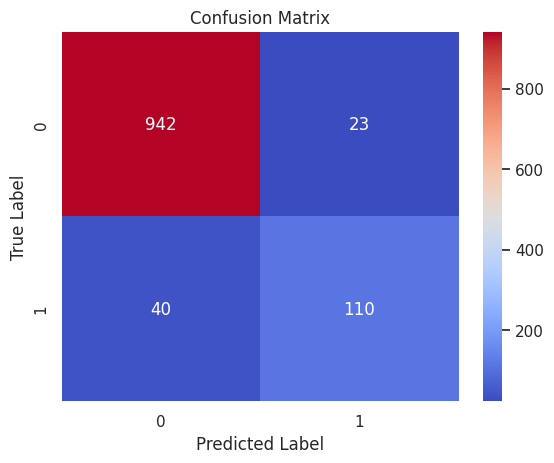

In [57]:
# Calculate other metrics
precision = precision_score(test_data['label'], predictions)
recall = recall_score(test_data['label'], predictions)
f1 = f1_score(test_data['label'], predictions)

# Print the results
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Print the confusion matrix
cm = confusion_matrix(test_data['label'], predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Based on the provided metrics:

1. Accuracy: The model correctly classifies approximately 94.35% of all data points.
2. Precision: Around 82.71% of the items classified as positive are actually true positives.
3. Recall: About 73.33% of the actual positives are correctly identified by the model.
4. F1 Score: The harmonic mean of precision and recall is approximately 77.74%.

The Precision and Recall scores indicate that the model performs reasonably well, but there is room for improvement. The relatively lower Recall score suggests that the model misses some of the actual positive instances. This could be attributed to the class imbalance issue you mentioned – if there are significantly more non-spam instances in the data, the model may not be trained well enough to recognize the less frequent spam instances.

To enhance the model's performance, you may consider techniques such as resampling the data to balance the classes, using different algorithms that handle class imbalance better, or adjusting the classification threshold. Additionally, further feature engineering or exploring more sophisticated machine learning techniques could help improve the model's ability to distinguish between spam and non-spam instances.

## Conclusion
The code successfully implements a machine learning model for email spam detection using a Convolutional Neural Network (CNN). Here are the key conclusions:

1. **Data Preparation**:
   - The dataset is effectively prepared for training by applying text preprocessing techniques like tokenization, stemming, and removing stopwords.
   - The dataset is split into training and testing sets for model evaluation.

2. **Model Architecture**:
   - A CNN model is defined for text classification, designed to process text sequences and predict whether an email is spam or non-spam.

3. **Training**:
   - The model is trained using the training dataset with a defined architecture.
   - The training loop runs for multiple epochs, optimizing the model parameters to minimize the cross-entropy loss.
   - The training loss consistently decreases over epochs, indicating effective learning and improvement.

4. **Evaluation**:
   - After training, the model is evaluated on the test dataset to assess its performance.
   - Metrics such as accuracy, precision, recall, and F1 score are calculated, providing insights into the model's effectiveness in classifying spam and non-spam emails.
   - A confusion matrix is generated to visualize the model's performance in terms of true positive, false positive, true negative, and false negative predictions.

5. **Conclusion**:
   - The model achieves high accuracy and reasonable precision and recall scores, indicating its effectiveness in distinguishing between spam and non-spam emails.
   - Suggestions for further improvement include addressing class imbalance, exploring alternative algorithms, adjusting classification thresholds, and conducting feature engineering.

Overall, the code demonstrates a comprehensive approach to building, training, and evaluating a machine learning model for email spam detection, with potential avenues for enhancement to achieve even better performance.